In [1]:
from model.img2img_model import StableDiffusionImg2Img
from model.segment_anything_model import SAM
from PIL import Image
import numpy as np 
from model.Inpaint_Anything.lama_inpaint import inpaint_img_with_lama
from model.Inpaint_Anything.utils import save_array_to_img, dilate_mask

Detectron v2 is not installed


In [2]:
LAMA_CONFIG = 'model/Inpaint_Anything/lama/configs/prediction/default.yaml'
LAMA_MODEL = 'model/Inpaint_Anything/pretrained_models/big-lama'
check_point_dump_path = "/opt/ml/level3_cv_finalproject-cv-16/GPUserver/model/weights/dump_paths/corneos7th_heaven_mix_v2-anythingv3"

In [3]:
image_translation = StableDiffusionImg2Img(check_point = check_point_dump_path)
segmentation = SAM()

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/opt/ml/level3_cv_finalproject-cv-16/venv/lib/python3.8/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


In [4]:
lts = {'left': 384, 'top': 394, 'width': 370, 'height': 293}
{'left': 364, 'top': 362, 'width': 205, 'height': 506}

In [158]:
#lts
# input_bbox = np.array([int(384*1.6),int(394*1.6),int(754*1.6),int(687*1.6)])
#lts friend
# input_bbox = np.array([int(29*1.6),int(136*1.6),int(365*1.6),int(580*1.6)])

# input_bbox = np.array([int(413*1.5),int(588*1.5),int(604*1.5),int(997*1.5)])
#lsm, 
input_bbox = np.array([364,362,569,868])
image = Image.open("lsm.jpeg")

In [159]:
# image = image.resize((1024,1024))

In [160]:
image.size

(904, 868)

In [161]:
# bbox_area = (input_bbox[2]-input_bbox[0])*(input_bbox[3]-input_bbox[1])
mask = segmentation.make_mask_with_bbox(image,input_bbox)

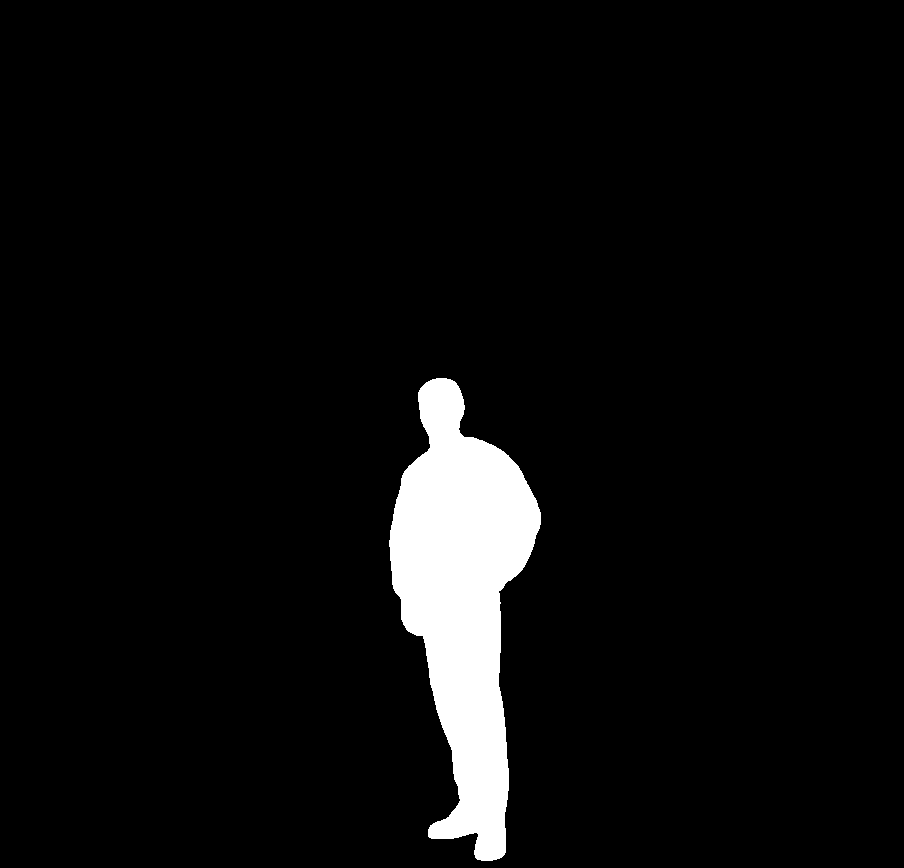

In [162]:
mask

In [163]:
from model.utils import image_resize,image_segmentation,combine_image, check_crop_inference,crop_coord,img_padding


In [164]:
x1,y1,x2,y2,cropped_bbox= crop_coord(image=image,bbox=input_bbox)
cropped_img = image.crop((x1,y1,x2,y2))
cropped_mask = mask.crop((x1,y1,x2,y2))

x1,y1,x2,y2,cropped_bbox


(172, 321, 760, 868, array([192,  41, 397, 547]))

(588, 547)


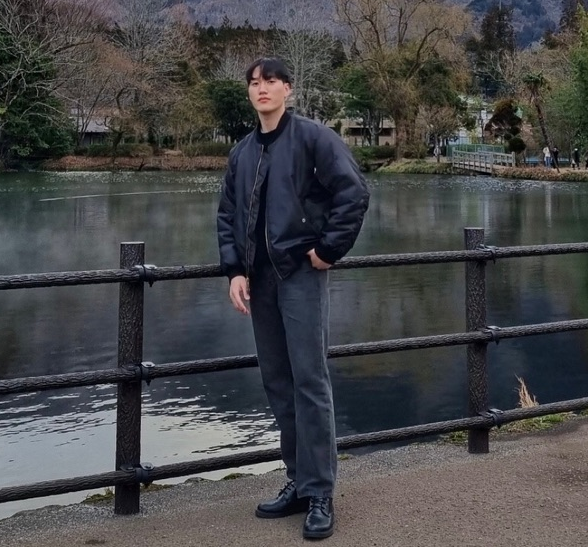

In [165]:
print(cropped_img.size)
cropped_img

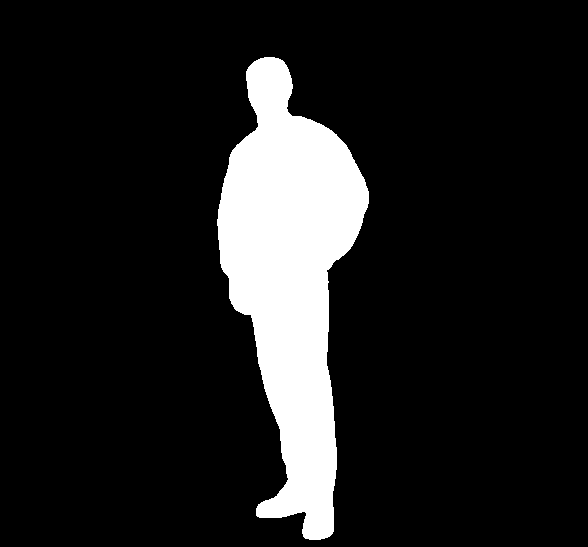

In [166]:
cropped_mask

In [167]:
segment_img = image_segmentation(cropped_img,cropped_mask)


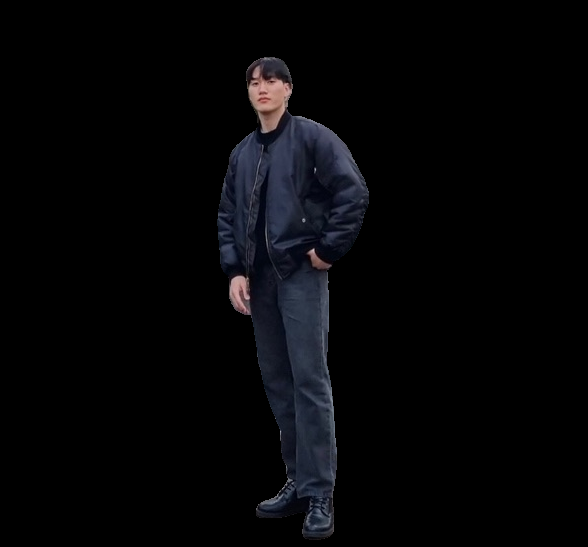

In [168]:
segment_img

In [169]:

lora_path = f"model/weights/diffusion/Lora/ghdtl/checkpoint"
image_translation.load_Lora(lora_path)
prompt,negative_prompt = "(ghdtl anime character), perfect eyes","watermark, text, error, blurry, jpeg artifacts, cropped, worst quality, low quality, signature, username, artist name, bad anatomy, nsfw, realistic, awkward face, scary eyes, awkward eyes, without pupils"

In [172]:
resize_img  = segment_img.resize((880,880))

In [173]:
target_image = image_translation.inpaint(prompt=prompt,negative_prompt=negative_prompt,image=resize_img,num_inference_steps=120,strength=0.55)

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

In [140]:
target_image = target_image.resize(segment_img.size)

In [142]:
target_image.size

(588, 547)

In [143]:
def outpaint(image:Image.Image,mask:Image.Image,dilate_kernel_size:int) -> Image.Image:
        mask = np.array(mask)
        mask = dilate_mask(np.array(mask),dilate_kernel_size)
        background = Image.fromarray(inpaint_img_with_lama(
    np.array(image), mask, LAMA_CONFIG, LAMA_MODEL, device="cuda"))
        return background

In [144]:
background = outpaint(image,mask,15)

In [145]:
background.size

(904, 868)

In [146]:
def segment_image(image:Image.Image,input_bbox:np.array) -> Image.Image:
    mask = segmentation.make_mask_with_bbox(image,input_bbox)
    return mask

In [147]:
x1,y1,x2,y2,np.array(target_image).shape


(172, 321, 760, 868, (547, 588, 3))

In [148]:
#어째서 segment_img는 사이즈가 (500, 482) 인데,
# segment_img의 인퍼런스 결과인 target_image는 (496, 480)이다
segment_img.size,target_image.size


((900, 900), (588, 547))

In [156]:
w,h = image.size 


In [157]:
target_image.resize((w,h)).size

AttributeError: 'NoneType' object has no attribute 'size'

In [151]:
w,h = segment_img.size 
target_image = target_image.resize((w,h))

In [152]:
target_image.size

(900, 900)

In [153]:
image.size

(904, 868)

In [154]:
# target_image = img_padding(image=image,target_image=target_image,coord = (x1,y1,x2,y2))
# target_image = Image.fromarray(target_image)

w_t,h_t = image.size
w,h = target_image.size
target_image = np.array(target_image,dtype= np.uint8)
zero_array = np.zeros((h_t,w_t,3),dtype= np.uint8)
zero_array[y1:y1+h,x1:x1+w,:] = target_image
target_image = Image.fromarray(target_image)

w,h,w_t,h_t




ValueError: could not broadcast input array from shape (900,900,3) into shape (547,732,3)

In [ ]:
target_image = Image.fromarray(zero_array)

In [155]:
target_image.size

2430000

In [113]:
background.size

(1638, 1100)

In [114]:
target_mask = segment_image(image = target_image,input_bbox=input_bbox)


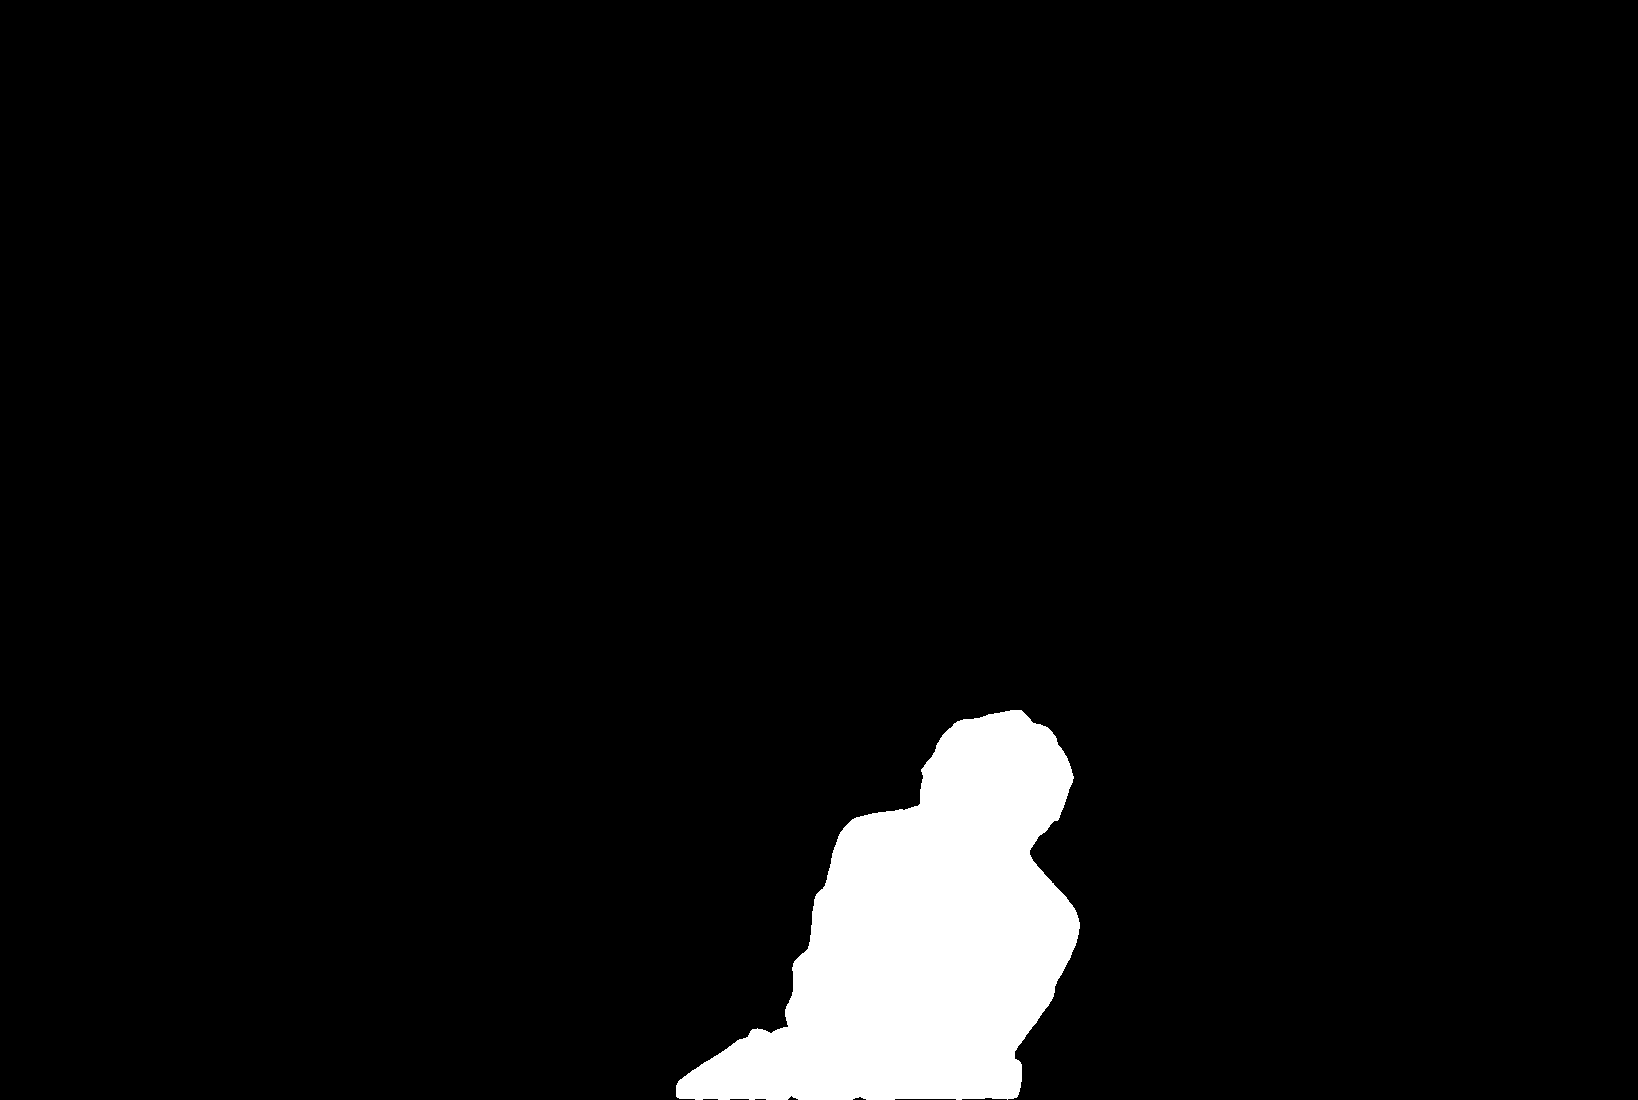

In [115]:
target_mask

In [116]:
target_image.size, target_mask.size,background.size

((1638, 1100), (1638, 1100), (1638, 1100))

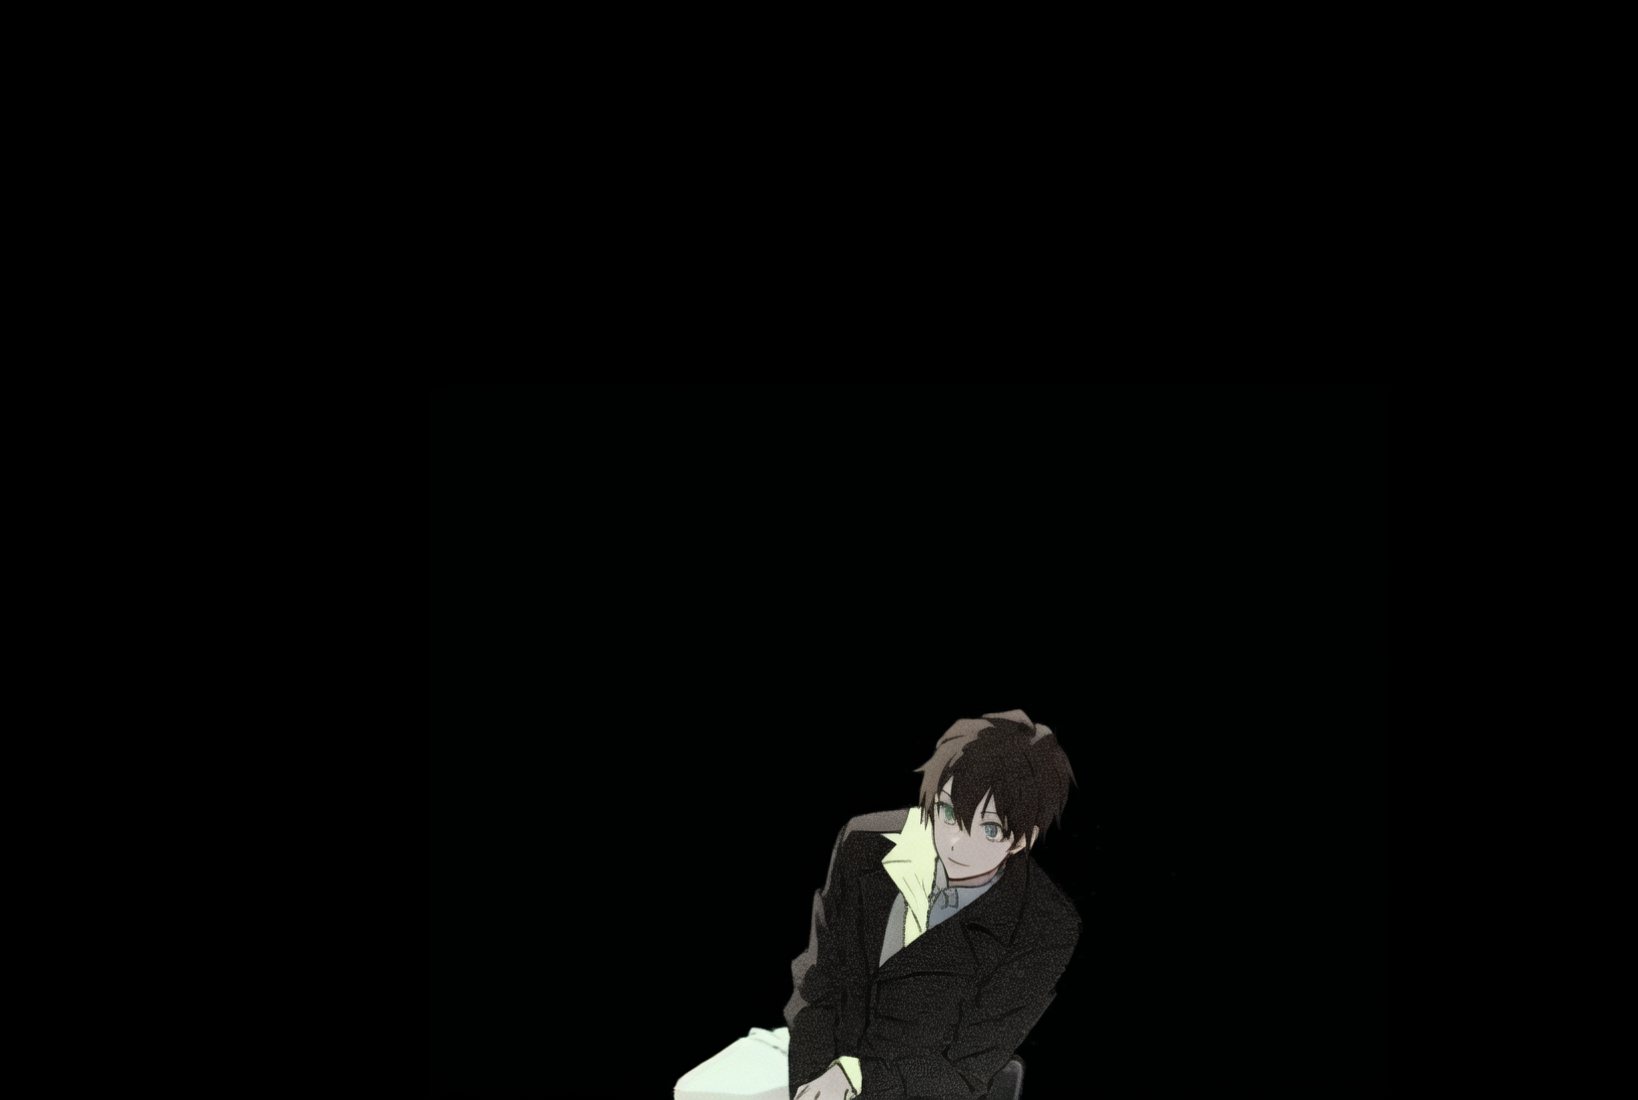

In [117]:
target_image

In [118]:
target_image,target_background = image_segmentation(image=target_image,mask=target_mask,background=background)  

In [119]:
result = combine_image(background=target_background,image=target_image)

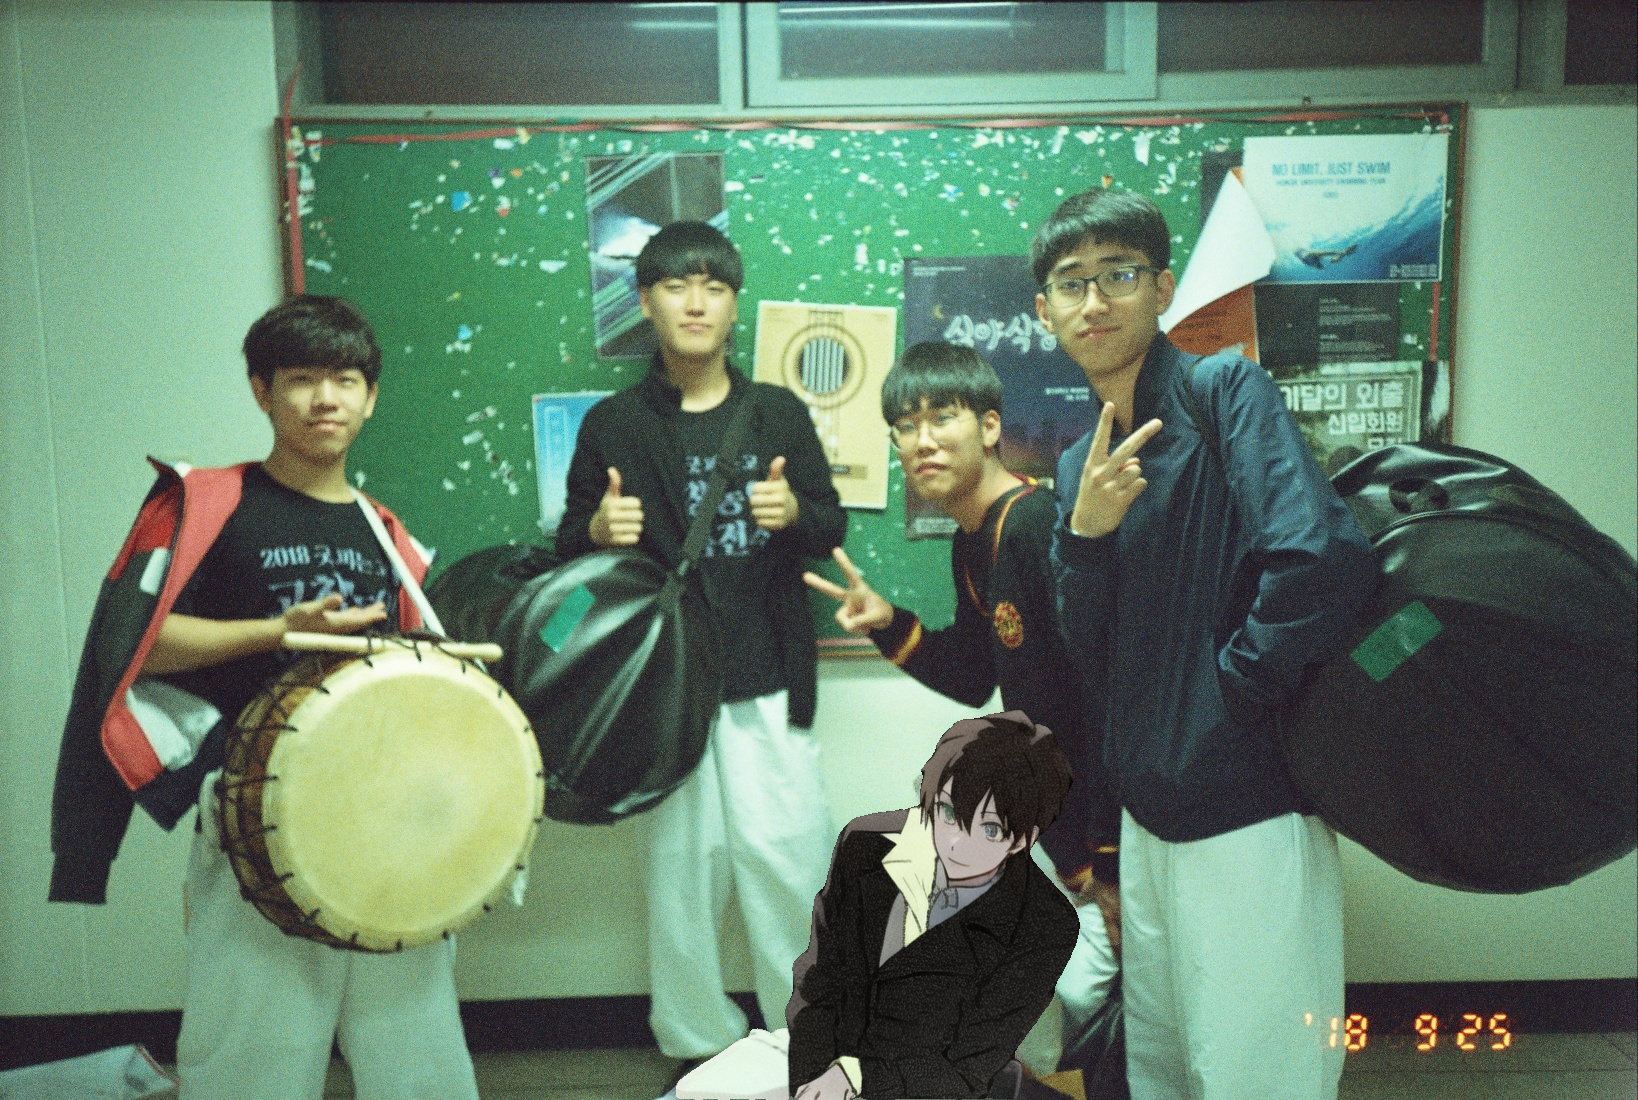

In [120]:
# result.save("ghdtl_tkdals.jpg")
result